# Introduction

In [ ]:
"""
What? Visualizing the stock market structure

Reference: https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py
"""

# Import libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd
from sklearn import cluster, covariance, manifold

# Load dataset

In [ ]:
"""
Retrieve the data from Internet

The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
that we get high-tech firms, and before the 2008 crash). This kind of
historical data can be obtained for from APIs like the quandl.com and
alphavantage.co ones.
"""

In [2]:
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    quotes.append(pd.read_csv(url.format(symbol)))

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote h

# Learn a graphical structure from the correlations

In [ ]:
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# Cluster using affinity propagation

In [4]:
_, labels = cluster.affinity_propagation(edge_model.covariance_,
                                         random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: McDonald's
Cluster 8: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 9: Kellogg, Coca Cola, Pepsi
Cluster 10: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 11: Canon, Honda, Navistar, Sony, Toyota, Xerox


# Find a low-dimension embedding for visualization:

In [ ]:
"""
Find a low-dimension embedding for visualization: find the best position of
the nodes (the stocks) on a 2D plane

We use a dense eigen_solver to achieve reproducibility (arpack is
initiated with random vectors that we don't control). In addition, we
use a large number of neighbors to capture the large-scale structure
"""

In [5]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# Plotting

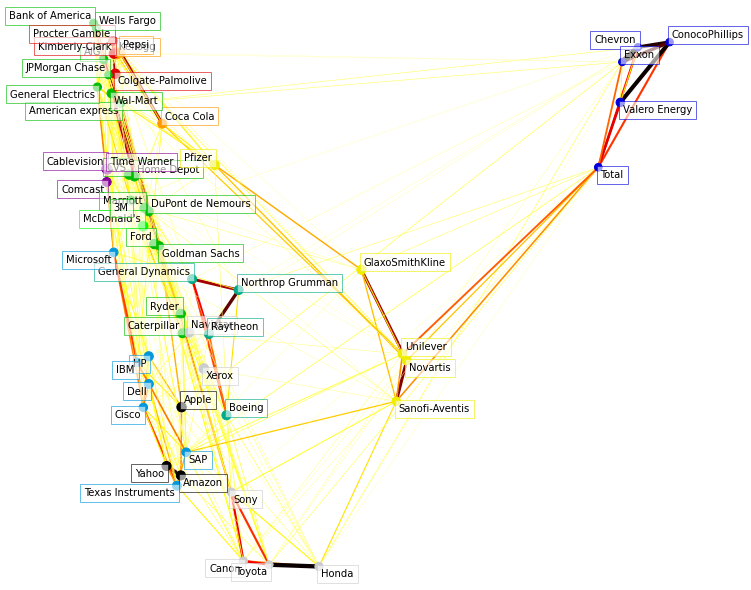

In [6]:
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()